In [10]:
import torch
from IPython.core.pylabtools import figsize
from torchinfo import summary
from tqdm import tqdm
import TorchData
import matplotlib.pyplot as plt

In [11]:
import importlib
importlib.reload(TorchData)

<module 'TorchData' from '/home/lukelele/Documents/ResearchProject/TorchData/__init__.py'>

In [12]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [13]:
train_dataset = TorchData.TORCHDataset(num_data=5096, signal_count=25, noise_density=0.01, dispersion_intensity=1)
test_dataset = TorchData.TORCHDataset(num_data=1, signal_count=25, noise_density=0.01)

train_dataloader = train_dataset.dataloader(batch_size=256, shuffle=True)
test_dataloader = test_dataset.dataloader(batch_size=1, shuffle=False)

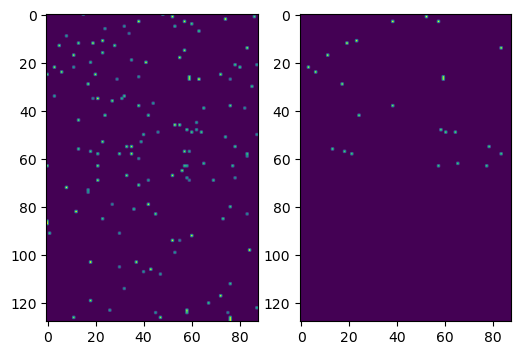

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(6, 10))
data = next(iter(train_dataloader))
ax[0].imshow(data[0][0].squeeze(0))
ax[1].imshow(data[1][0].squeeze(0))

In [15]:
class LearnablePositionalEncoding(torch.nn.Module):
    def __init__(self, embed_dim=64, seq_length=704):
        super().__init__()
        self.pos_embed = torch.nn.Parameter(
            torch.zeros(1, seq_length, embed_dim),
            requires_grad=True
        )
        torch.nn.init.normal_(self.pos_embed, std=0.02)  # Xavier-style initialization

    def forward(self, x):
        B, seq, embed_size = x.shape
        return x + self.pos_embed

In [16]:
class HybridTransformer(torch.nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_layers=2):
        super().__init__()
        
        # CNN Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.GELU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.GELU(),
            torch.nn.MaxPool2d(2)
        )

        # Transformer
        self.transformer = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=4*embed_dim,
                batch_first=True,
                norm_first=True,  # Better stability
                dropout=0.1
            ),
            num_layers=num_layers
        )

        
        # CNN Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.GELU(),
            torch.nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.GELU(),
            torch.nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
        )

        # self.pos_embed = torch.nn.Parameter(torch.randn(1, 690, embed_dim))
        self.learnable_position_embed = LearnablePositionalEncoding(embed_dim)
        # self.fixed_pos_embed = PositionalEncoding(embed_dim)

    def forward(self, x):
        # Encoder
        cnn_features = self.encoder(x)  # [B, 64, H/4, W/4]
        
        # Transformer processing
        B, C, H, W = cnn_features.shape
        x = cnn_features.flatten(2).permute(0, 2, 1)

        # x = x + self.pos_embed[:, :H*W, :]
        # x = self.fixed_pos_embed(x)
        x = self.learnable_position_embed(x)
        x = self.transformer(x)
        
        # Feature fusion
        x = x.permute(0, 2, 1).view(B, C, H, W)
        x = x + cnn_features  # Residual connection
        
        # Decoder
        return self.decoder(x)

In [27]:
model = HybridTransformer().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
summary(model, input_size=(1, 1, 128, 88))

Layer (type:depth-idx)                        Output Shape              Param #
HybridTransformer                             [1, 1, 128, 88]           --
├─Sequential: 1-1                             [1, 64, 32, 22]           --
│    └─Conv2d: 2-1                            [1, 32, 128, 88]          320
│    └─BatchNorm2d: 2-2                       [1, 32, 128, 88]          64
│    └─GELU: 2-3                              [1, 32, 128, 88]          --
│    └─MaxPool2d: 2-4                         [1, 32, 64, 44]           --
│    └─Conv2d: 2-5                            [1, 64, 64, 44]           18,496
│    └─BatchNorm2d: 2-6                       [1, 64, 64, 44]           128
│    └─GELU: 2-7                              [1, 64, 64, 44]           --
│    └─MaxPool2d: 2-8                         [1, 64, 32, 22]           --
├─LearnablePositionalEncoding: 1-2            [1, 704, 64]              45,056
├─TransformerEncoder: 1-3                     [1, 704, 64]              --
│    └─Mod

In [29]:
for epoch in tqdm(range(10)):
    for sn_time, signal_time in train_dataloader:
        optimiser.zero_grad()
        outputs = model(sn_time.to(device))
        loss = loss_function(outputs, signal_time.to(device))
        loss.backward()
        optimiser.step()

100%|██████████| 10/10 [01:11<00:00,  7.14s/it]


In [30]:
### Using pretrained weights
# model.load_state_dict(torch.load("model_weights.pth", weights_only=True))

In [31]:
model.eval()

with torch.no_grad():
    pred = model.to("cpu")(next(iter(test_dataloader))[0].to("cpu"))

Text(0.5, 1.0, 'Reconstructed Image')

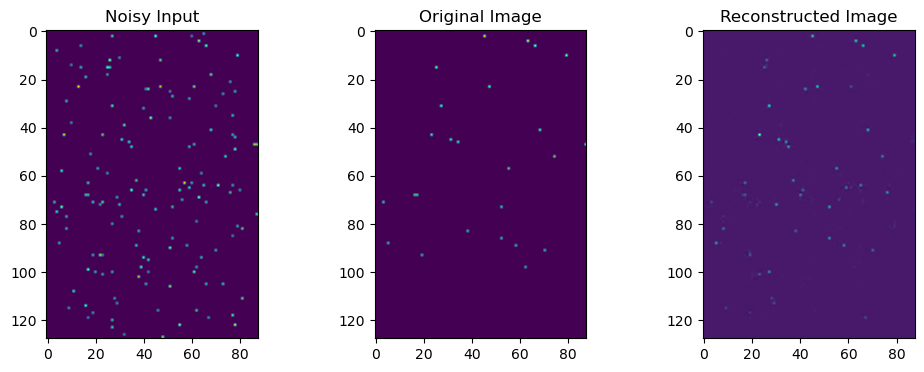

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(next(iter(test_dataloader))[0].squeeze(0).squeeze(0).to("cpu"))
ax[1].imshow(next(iter(test_dataloader))[1].squeeze(0).squeeze(0).to("cpu"))
ax[2].imshow(pred[0].squeeze(0))

ax[0].set_title("Noisy Input")
ax[1].set_title("Original Image")
ax[2].set_title("Reconstructed Image")

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-17.28673935, -14.74880219, -12.21086502,  -9.67292786,
         -7.13499069,  -4.59705353,  -2.05911636,   0.4788208 ,
          3.01675797,   5.55469513,   8.09263229,  10.63056946,
         13.16850662,  15.70644379,  18.24438095,  20.78231812,
         23.32025528,  25.85819244,  28.39612961,  30.93406677,
         33.47200394,  36.0099411 ,  38.54787827,  41.08581543,
         43.62375259,  46.16168976,  48.69962692,  51.2375679 ,
         53.77550125,  56.3134346 ,  58.85137558,  61.38931656,
         63.92724991,  66.46517944,  69.00312805,  71.5410614 ,
         74.07899475,  76.6169281 ,  79.15487671,  81.69281006,
         84.23074341,  86.76867676,  89.30662537,  91.84455872,
         94.38249207,  96.92042542,  99.4583740

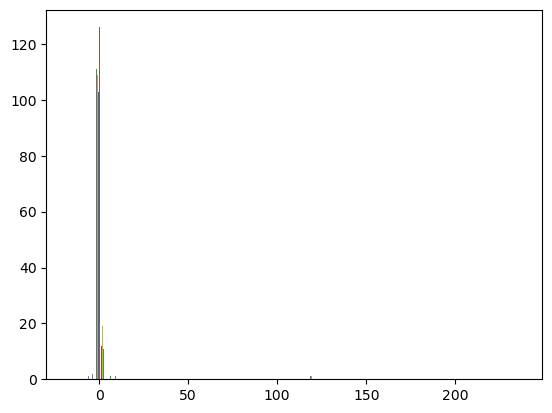

In [33]:
plt.hist(pred[0].squeeze(0), bins=100)